In [1]:
from ngsolve import *
from netgen.meshing import meshsize
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
from A_Phi_Method import Ht_regularization
sys.path.append('..\model')
sys.path.append('..\COIL\include')
from Team7Model import Team7Model 
model=Team7Model(msize=meshsize.coarse, boxsize=1)
DrawGeo(model.geo)
mesh=model.mesh
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [2]:
import math
feorder=4
Dirichlet=False
jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
    


enter iccg_solve
Dof= 236161    Nonzeros= 22304568
shift parameter= 1.1400000000000001
minimum residual= nan  at iteraions:  0


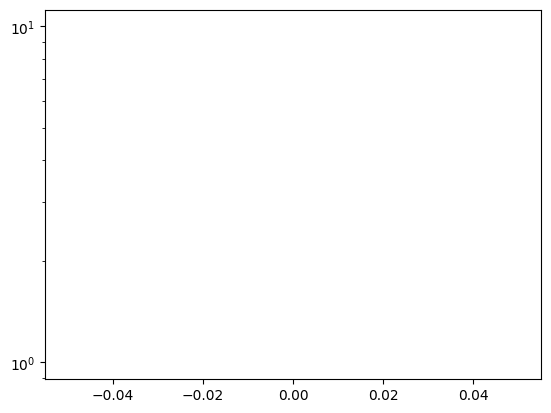

ICCG calculation time (sec): 4.2596341999887954


In [3]:
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
symmetric_plane=model.symmetric_plane
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary

coil=model.coil.field
#coil=UNIF(0,0,0.01,0)
As=Afield(coil)
Bs=Bfield(coil)
mu=4.e-7*math.pi
Hs=Bs/mu
Asr=model.ReducedField(As, (0,0,0))
Bsr=model.ReducedField(Bs, (0,0,0))

if Dirichlet==True:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane+'|'+reduced_boundary, nograds=True, complex=jomega)
else:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane, nograds=True, complex=jomega) 
fesPhi=H1(mesh, order=feorder, definedon=conductive_region, complex=jomega) 
fesAPhi=fesA*fesPhi
(A,phi), (N, psi) = fesAPhi.TnT() 
gfAPhi = GridFunction(fesAPhi)
gfA, gfPhi=gfAPhi.components

normal = specialcf.normal(mesh.dim)
a= BilinearForm(fesAPhi)
a +=1/Mu*curl(A)*curl(N)*dx
a +=s*Sigma*(A+grad(phi))*(N+grad(psi))*dx(conductive_region)
with TaskManager():
    a.Assemble()

# Calculate Dirichlet condition terms
gfA.Set(As, BND, mesh.Boundaries(total_boundary))
f = LinearForm(fesAPhi)
f +=1/Mu*curl(gfA)*curl(N)*dx(reduced_region)

with TaskManager():
    f.Assemble()    
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesAPhi.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesAPhi.FreeDofs()] = fcut

# Add Neumann condition terms
#hst=Ht_regularization(Hs, mesh, total_boundary, feorder)
f += Cross(N.Trace(),Hs)*normal*ds(total_boundary)
#f += Cross(N.Trace(),hst)*normal*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfAPhi= GridFunction(fesAPhi)   #Clear gfA
gfA, gfPhi=gfAPhi.components
gfAPhi=solver.iccg_solve(fesAPhi, gfAPhi, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, logplot=True, complex=jomega) 




In [4]:
fesAt=HCurl(mesh, order=feorder, definedon=total_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
fesAr=HCurl(mesh, order=feorder, definedon=reduced_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
At=GridFunction(fesAt)
Arr=GridFunction(fesAr)
Axr=GridFunction(fesAr)
At.Set(gfA,VOL, definedon=total_region)
Arr.Set(gfA,VOL, definedon=reduced_region)
Axr.Set(As, BND, mesh.Boundaries(total_boundary))

Bt=curl(At)
Ar=Arr-Axr
Br=curl(Arr)-curl(Axr)

Afield=At+Ar+Asr
Bfield=Bt+Br+Bsr
Jfield=-s*Sigma*(At+grad(gfPhi))

In [5]:
mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))

if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region), mesh)
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

center magnetic field =  (0j, 0j, 0j)
 Average Joule loss=  0.0


In [6]:
from netgen.occ import OCCGeometry
from ngsolve.comp import Mesh
from netgen.meshing import meshsize
#plotMesh=Mesh(OCCGeometry(model.conductor).GenerateMesh(meshsize.coarse)).Curve(1)

In [7]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh,order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    #print("****** Bfield ******")
    #Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

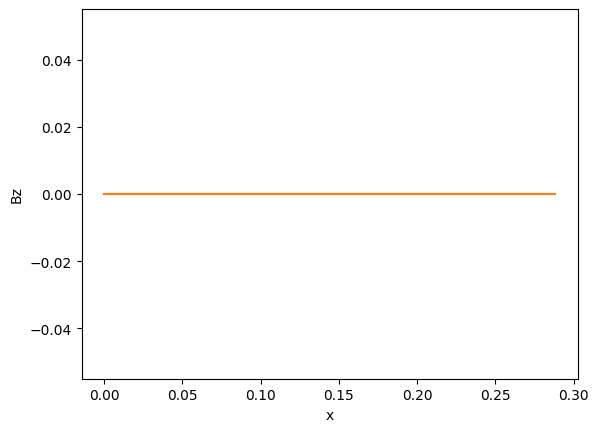

In [8]:
import matplotlib.pylab as plt
N=1000
x0=0
y0=0.072
z0=0.034
#z0=0.0265
x1=0.288
y1=y0
z1=z0
dx=(x1-x0)/N
dy=(y1-y0)/N
dz=(z1-z0)/N
xp=[]
yvreal=[]
yvimag=[]
x=x0
y=y0
z=z0
for n in range(N+1):
    pnt=mesh(x,y,z)
    #print( "x= ", x, "  Bz= ", Bfield(pnt)[2].real, "  ", Bfield(pnt)[2].imag)
    xp.append(x)
    val=Bfield(pnt)[2]
    yvreal.append(val.real)
    yvimag.append(val.imag)
    #print("x=", x, "  Bz real=", val)
    x=x+dx
    y=y+dy
    z=z+dz

plt.plot(xp, yvreal)  
plt.xlabel("x")  # Add x-axis label
#plt.ylabel("Bz")  # Add y-axis label
plt.plot(xp, yvimag ) 
plt.xlabel("x")  # Add x-axis label
plt.ylabel("Bz")  # Add y-axis label
plt.show()  